In [1]:
import requests
import pandas as pd

In [2]:
raw_data = {
    # Weight-for-length boys
    'wfl_b': requests.get('https://www.who.int/childgrowth/standards/wfl_boys_p_exp.txt').text,
    # Weight-for-length girls
    'wfl_g': requests.get('https://www.who.int/childgrowth/standards/wfl_girls_p_exp.txt').text,
    # Weight-for-height boys
    'wfh_b': requests.get('https://www.who.int/childgrowth/standards/wfh_boys_p_exp.txt').text,
    # Weight-for-height girls
    'wfh_g': requests.get('https://www.who.int/childgrowth/standards/wfh_girls_p_exp.txt').text
}

In [3]:
data_frames = dict()

for tag, data in raw_data.items():
    # Convert data string into list of lists
    matrix = [row.split('\t') for row in data.split('\r\n')]

    # Get columns names from first row
    columns = matrix.pop(0)

    # Remove the empty row at the end
    matrix.pop()

    df = pd.DataFrame(data=matrix, columns=columns).astype('float64')

    # Turn column 1 into index
    df.index = df.iloc[:,0]
    df.drop(columns=df.columns[0], inplace=True)
    
    data_frames[tag] = df

In [11]:
# Following WHO instructions https://www.who.int/childgrowth/standards/readme_wflh_exp.pdf?ua=1
# Using weight-for-length for 45cm - 86cm and weight-for-height 87cm - 120cm
wflh_b = data_frames['wfl_b'].loc[45:86].append(data_frames['wfh_b'].loc[87:120])
wflh_b.index.rename('Length/Height', inplace=True)
wflh_g = data_frames['wfl_g'].loc[45:86].append(data_frames['wfh_g'].loc[87:120])
wflh_g.index.rename('Length/Height', inplace=True)

wflh_b

,L,M,S,P01,P1,P3,P5,P10,P15,P25,P50,P75,P85,P90,P95,P97,P99,P999
Length/Height,,,,,,,,,,,,,,,,,,
45.0,-0.3521,2.4410,0.09182,1.863,1.987,2.064,2.107,2.175,2.223,2.296,2.441,2.599,2.689,2.753,2.851,2.917,3.048,3.292
45.1,-0.3521,2.4577,0.09176,1.876,2.001,2.079,2.122,2.190,2.238,2.312,2.458,2.616,2.707,2.771,2.870,2.937,3.068,3.313
45.2,-0.3521,2.4744,0.09170,1.889,2.014,2.093,2.136,2.205,2.254,2.328,2.474,2.634,2.726,2.790,2.889,2.956,3.089,3.335
45.3,-0.3521,2.4911,0.09164,1.902,2.028,2.107,2.151,2.220,2.269,2.343,2.491,2.652,2.744,2.809,2.908,2.976,3.109,3.357
45.4,-0.3521,2.5078,0.09159,1.915,2.042,2.122,2.165,2.235,2.284,2.359,2.508,2.669,2.762,2.827,2.928,2.996,3.130,3.379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119.6,-0.3521,22.1945,0.09399,16.832,17.979,18.697,19.093,19.725,20.167,20.846,22.195,23.664,24.507,25.101,26.019,26.639,27.865,30.152
119.7,-0.3521,22.2341,0.09406,16.859,18.008,18.728,19.125,19.758,20.202,20.882,22.234,23.707,24.553,25.149,26.068,26.690,27.920,30.213
119.8,-0.3521,22.2738,0.09412,16.886,18.038,18.759,19.157,19.792,20.237,20.918,22.274,23.751,24.598,25.196,26.117,26.741,27.974,30.273


In [42]:
wflh_b.to_json('who_charts.json')

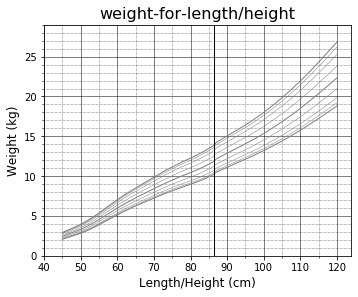

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5.5, 4.25))

wflh_b.plot(
    #x=wflh_b.index,
    y=['P3', 'P50', 'P97'],
    kind='line', 
    ax=ax, 
    color='gray', 
    linewidth='1'
)
wflh_b.plot(
    #x=wflh_b.index,
    y=['P5', 'P10', 'P25', 'P75', 'P90', 'P95'],
    kind='line', 
    ax=ax, 
    color='gray', 
    linewidth='0.5'
)

ax.set_title('weight-for-length/height', color='black', fontsize=16)
ax.set_ylabel('Weight (kg)', color='black', fontsize=12)
ax.set_xlabel('Length/Height (cm)', color='black', fontsize=12)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

start, end = ax.get_xlim()
start = 5 * round(start/5)
end = 5 * round(end/5)
ax.set_xticks(np.arange(start, end, 10))
ax.set_xticks(np.arange(start, end, 5), minor=True)

start, end = ax.get_ylim()
start = 5 * round(start/5)
end = 5 * round(end/5)
ax.set_yticks(np.arange(start, end, 5))
ax.set_yticks(np.arange(start, end, 1), minor=True)

ax.grid(which='major', linewidth='0.5', linestyle='-', color='black')
ax.grid(which='minor', linewidth='0.5', linestyle=':', color='black')

plt.axvline(x=86.5, color='black', linewidth='1')

ax.legend().remove()
